<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Instantiate-CPPN" data-toc-modified-id="Instantiate-CPPN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Instantiate CPPN</a></span></li><li><span><a href="#Generate-Image" data-toc-modified-id="Generate-Image-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate Image</a></span><ul class="toc-item"><li><span><a href="#Export" data-toc-modified-id="Export-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Export</a></span></li></ul></li><li><span><a href="#Animation" data-toc-modified-id="Animation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Animation</a></span></li><li><span><a href="#Parameters-Grid-Search" data-toc-modified-id="Parameters-Grid-Search-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters Grid Search</a></span></li><li><span><a href="#Considerations" data-toc-modified-id="Considerations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Considerations</a></span></li></ul></div>

In [2]:
import numpy as np
import yaml
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from datetime import datetime

from pathlib import Path

plt.rcParams['animation.ffmpeg_path'] = str(Path.home() / "anaconda3/envs/image-processing/bin/ffmpeg")

%matplotlib notebook

%load_ext autoreload
%autoreload 2

from CPPN import CPPN

Using TensorFlow backend.


# Instantiate CPPN

In [3]:
res_path = Path.home() / 'Documents' / 'datasets' / 'cppn'

In [4]:
extra_funs= {
    'base': lambda x,y: x*y,
    'cos_sin': lambda x,y: np.cos(x)*np.sin(y),
    'cube': lambda x,y: x**3 + 3*y - y**3 -3*x,
    'rand': lambda x,y: np.sqrt(x*x+y*y) + (x*x) + np.tan(y),
}

In [6]:
# load config file
with open('cppn_config.yaml', 'r') as f:
    model_config = yaml.load(f)
model_config = model_config['base_bw']
model_config

{'hidden_dim': 32,
 'inner_activation': 'tanh',
 'inner_architecture_key': 'base',
 'kernel_init_mean': 0.0,
 'kernel_init_stddev': 1.0,
 'nb_channels': 1,
 'nb_hidden_layers': 3,
 'scale_factor': 1.0,
 'z_dim': 32}

In [ ]:
# OPTIONALLY customize model config
model_config['nb_hidden_layers'] = 8
#model_config['kernel_init_stddev'] = 1.
model_config['kernel_init_mean'] = 0.
model_config['nb_channels'] = 1

#model_config['inner_architecture_key'] = 'residual'

In [13]:
# init model
batch_size = 5

img_width = 1080
img_height = 1080
img_size = (img_width, img_height)

cppn = CPPN(batch_size=batch_size, img_width=img_width, img_height=img_height, 
            **model_config)

In [ ]:
cppn.model.summary()

# Generate Image

In [14]:
x, y, r, e = cppn.get_data(extra_fun=extra_funs['base'])

In [15]:
z = cppn.get_z()

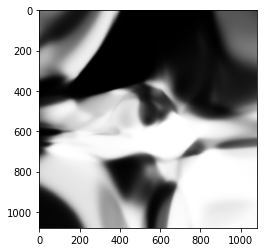

In [16]:
result_imgs = cppn.generate_imgs(x, y, r, e, z)
plt.imshow(result_imgs[0], cmap='gray')

## Export

In [19]:
# export results as numpy
np.save(str(res_path / 'numpy_exports/bw_1080.npy'), result_imgs)

In [21]:
# test load results
np.load(str(res_path / 'numpy_exports/bw_1080.npy')).shape

(5, 1080, 1080)

In [22]:
# export as images
for i, img in enumerate(result_imgs): 
    plt.imsave(str(res_path / f'numpy_exports/sample_{i}.png'), img, cmap='gray')

# Animation

In [ ]:
save_anim = False    # whether to save animation to file
animate_data = True  # whether to retrieve new input data at each animation frame
FRAMES = 300
batch_size = 1
img_width = 1080
img_height = 720
img_size = (img_width, img_height)

# Setup plot
dpi = 100
if save_anim:
    fig, ax = plt.subplots(dpi=dpi, figsize=(img_width/dpi, img_height/dpi))
else:
    fig, ax = plt.subplots(dpi=dpi, figsize=(5, 5))
plt.axis('off')

# Init model and data
with open('cppn_config.yaml', 'r') as f:
    model_config = yaml.load(f)
data_config = model_config['test_config']
model_config = model_config['rgb_test']
cppn = CPPN(batch_size=batch_size, img_width=img_width, img_height=img_height, 
            **model_config)
x, y, r, e = cppn.get_data(scale=data_config['scale'], 
                           translation=data_config['translation'],
                           rotation=data_config['rotation'], 
                           extra_fun=extra_funs[data_config['extra_fun']])
z = cppn.get_z()

z_max_val = 1
#z = np.zeros((1, model_config['z_dim']))-z_max_val
add_val = (z_max_val*2)/FRAMES
add_val = 1.0
def animate(i, ax, cppn, x, y, r, e, z, data_config, extra_funs, animate_data):
    z_idx = int(i/(int(FRAMES/model_config['z_dim'])))
    z[0][z_idx] += add_val
    #z[0] += add_val
    
    if animate_data:
        x, y, r, e = cppn.get_data(scale=data_config['scale']+i*data_config['scale_speed'], 
                                   translation=data_config['translation']+i*data_config['translation_speed'], 
                                   rotation=data_config['rotation']+i*data_config['rotation_speed'], 
                                   extra_fun=extra_funs[data_config['extra_fun']])
    
    ax.imshow(cppn.generate_imgs(x, y, r, e, z)[0], cmap='gray')

# Animate
ani = animation.FuncAnimation(fig, animate, frames=FRAMES, interval=10,
                              fargs=[ax, cppn, x, y, r, e, z, data_config, extra_funs, animate_data])
if save_anim:
    ani.save(str(res_path / 'tests' / 'anim_{}.mp4'.format(datetime.strftime(datetime.now(), "%Y-%m-%d_%H-%M"))), 
             animation.FFMpegFileWriter(fps=30))

# Parameters Grid Search

In [5]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {
                'inner_architecture_key': ['base', 'residual', 'softplus'],
                'kernel_init_stddev': np.linspace(0.7, 4., num=4),
                'scale': np.linspace(-2., 2., num=5),
                'translation': np.linspace(-4., 4., num=3),
                #'rotation': np.linspace(1, 360, num=4),
                'nb_hidden_layers': np.arange(3, 7, 2),
                'z_dim': [8, 16, 32, 64],
                'hidden_dim': [16, 32, 64],
                'extra_fun': ['base', 'cos_sin', 'cube', 'rand']
             }
grid = ParameterGrid(param_grid)

# Init model and data
with open('cppn_config.yaml', 'r') as f:
    model_config = yaml.load(f)
data_config = model_config['test_config']
model_config = model_config['rgb_test']

batch_size = 5
img_width = 1920
img_height = 1080

for i, params in enumerate(grid):
    print("Params {}: {}".format(i, params))
    out_dir = res_path / 'hq' / f'params_{i}'
    out_dir.mkdir(parents=True, exist_ok=False) 
    current_config = model_config.copy()
    current_data_config = data_config.copy()
    current_config.update(params)
    current_data_config.update(params)
    cppn = CPPN(batch_size=batch_size, img_width=img_width, img_height=img_height, 
                **current_config)
    x, y, r, e = cppn.get_data(scale=data_config['scale'], 
                               translation=data_config['translation'], 
                               rotation=data_config['rotation'],
                               extra_fun=extra_funs['cos_sin'])
    z = cppn.get_z()
    imgs = cppn.generate_imgs(x, y, r, e, z)
    for j, img in enumerate(imgs): 
        plt.imsave(str(out_dir / f'sample_{j}.png'), img, cmap='gray')

# Considerations

ReLu more interesting gradients but clear cut producing uninteresting entries for higher stddev.

Should use a bias_initializer? Should it be the same as kernel?

In general low kernel_init_stddev provides blurry results, still around 0.5. One can notice improvements with increased values for hidden_dim and even nb_hidden_layers, but still too much blur to be interesting. With 5.0 stddev we are instead already on the other opposite, with clear cute areas, cell-shading like.

Didn't notice major differenced when increasing the z_dim, sometimes even had impression of more interesting results with less